# DBN Structure Inference

The idea is to infer a posterior for the *structure* of a Dynamic Bayesian Network (DBN), given some data.

We formulate this task with the following model:

$$ P(G | X) \propto P(X | G) \cdot P(G) $$

* $P(G)$ is a prior distribution over DBN structures. We'll assume it has the form
$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$
where $|G \setminus G^\prime|$ denotes the number of edges in the graph, which are not present in some reference graph $G^\prime$.
* $P(X | G)$ is the marginal likelihood of the DBN structure. That is, it's the likelihood of the DBN after the network parameters have been integrated out -- it scores network *structure*. 
* If we assume some reasonable priors for network parameters, $P(X|G)$ can be obtained in closed form. In this work, we'll use the following marginal likelihood:
    
    $$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$ 
    where $X$ and $B$ are matrices obtained from data; and $n$ is the total number of timesteps in the dataset. This marginal likelihood results from an empirical prior over the regression coefficients, and an improper ($\propto 1/\sigma^2$) prior for the regression "noise" variables.

## Get some data

For now, we'll work with some data used by Hill et al. in their 2012 paper, _Bayesian Inference of Signaling Network Topology in a Cancer Cell Line_.

It gives the differential phosphorylation levels of 20 proteins, in a cancer cell line perturbed by EGF. This is a well-studied signaling pathway; the goal is to produce a graph describing the dependencies between proteins in this pathway. 

NOTE: I have confirmed that the ordering of proteins in `protein_vec` is identical to the ordering in the columns of `timeseries_data`. So we can depend on that.

## Build the model

Implement the graph prior distribution:

$$P(G) \propto \exp \left( -\lambda |G \setminus G^\prime| \right)$$

Implement the DBN's marginal distribution:

$$P(X | G) \propto \prod_{i=1}^p (1 + n)^{-(2^{|\pi(i)|} - 1)/2} \left( X_i^{+ T} X_i^+ - \frac{n}{n+1} X_i^{+ T} B_i (B_i^T B_i)^{-1} B_i^T X_i^+ \right)^{-\frac{n}{2}}$$

Some things to note:
* We're kind of shoe-horning this marginal likelihood into Gen. The probabilistic programming ethos entails modeling the entire data-generating process. This ought to provide better performance during inference, though.

A BUNCH OF HELPER FUNCTIONS:

THE MARGINAL LIKELIHOOD DISTRIBUTION

## Inference

### Metropolis-Hastings over directed graphs

Proposal distribution:

Involution function:

### Our inference program

# TESTING THE NEW MODEL

In [1]:
using Gen
using GLMNet
include("PSDiGraph.jl")
using .PSDiGraphs
include("dbn_preprocessing.jl")
include("dbn_models.jl")
include("dbn_proposals.jl")
include("dbn_inference.jl")
using PyPlot
using Profile
using ProfileView

In [2]:
timeseries_data_path = "data/mukherjee_data.csv"
protein_names_path = "data/protein_names.csv"
reference_adj_path = "data/prior_graph.csv"
timesteps_path = "data/time.csv"

"data/time.csv"

In [3]:
(timeseries_vec, protein_vec, ref_adj, timesteps) = hill_2012_preprocess(timeseries_data_path, 
                                                                         protein_names_path, 
                                                                         reference_adj_path, 
                                                                         timesteps_path);

In [4]:
Gen.load_generated_functions()

In [40]:
clear_caches()
regression_deg = 1
lambda_max = 10.0
n_samples = 200
fixed_lambda = 3.0
burnin = 100
thinning = 10
lambda_step = 0.3
V = length(protein_vec)
t = 0.4

results, acc = dbn_mcmc_inference(ref_adj, timeseries_vec, regression_deg, lambda_max,
                                  n_samples, burnin, thinning, 
                                  ps_smart_swp_update_loop,
                                  update_results_z_lambda!, #TODO
                                  (lambda_step,),
                                  ((V, t), V));
                                  #update_lambda=false,
                                  #fixed_lambda=fixed_lambda,
                                  #track_acceptance=true,
                                  #update_acceptances! =update_acc_z_lambda!) # TODO

In [41]:
transpose(results[1])

20×20 Transpose{Float64,Array{Float64,2}}:
  60.0   56.0   21.0  175.0    4.0  …   23.0    7.0   11.0    5.0   41.0
 157.0  200.0   34.0   16.0    5.0      11.0    6.0   15.0   18.0   45.0
   5.0    3.0   33.0    7.0  103.0     138.0   10.0   30.0  136.0   61.0
   8.0   12.0   16.0   49.0    9.0      12.0    3.0   32.0   90.0    5.0
  36.0   34.0  176.0   12.0  200.0     116.0   50.0   45.0   29.0    5.0
   5.0    3.0    6.0   22.0    9.0  …    0.0   30.0    5.0    6.0   35.0
   6.0   10.0   25.0  121.0   10.0      33.0   46.0   24.0   16.0   20.0
  20.0   21.0  145.0   11.0    9.0      11.0    4.0   11.0    7.0  191.0
   6.0    3.0   38.0   16.0    5.0     184.0  200.0   28.0   10.0   85.0
  15.0    3.0    5.0   12.0   11.0       8.0   45.0    3.0   11.0   12.0
  43.0   45.0   11.0   35.0    6.0  …    5.0   65.0   67.0   98.0    5.0
  15.0   28.0   26.0   34.0   12.0      14.0   11.0   22.0   27.0   27.0
   9.0    9.0    9.0   11.0   42.0       3.0   95.0    6.0    5.0   12.0
  43.0  

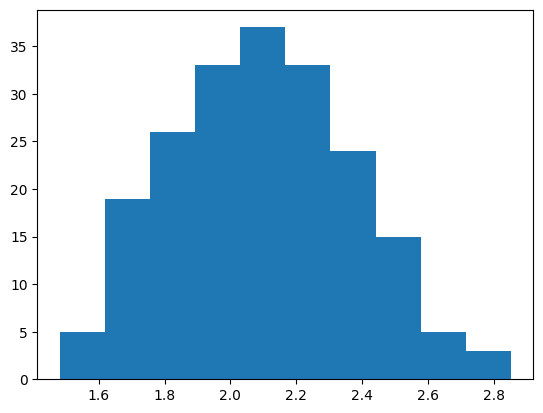

In [43]:
hist(results[2])
show()

In [7]:
# typeof(update_results_z_lambda!) <: Function

In [8]:
# matshow(transpose(ref_adj), cmap="Greys")
# matshow(transpose(edge_posterior), cmap="Greys")
# transpose(edge_posterior)[:,5]

In [9]:
# hill_result = convert(Matrix{Float64}, CSV.read("data/edge_prob_matrix.csv"))
# matshow(hill_result, cmap="Greys")
# hill_result[:,5]

In [10]:
a = [4,5,8]

3-element Array{Int64,1}:
 4
 5
 8

In [11]:
insert!(a, 4,11)

4-element Array{Int64,1}:
  4
  5
  8
 11

In [12]:
deleteat!(a, 4)

3-element Array{Int64,1}:
 4
 5
 8

In [13]:
searchsorted(a,6)

3:2

In [14]:
x = 23

23

In [15]:
x -= 1

22